## 0. Initialization
Import relevant modules and read the clean kaggle data (store as *df_raw*).

In [38]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mord

from sklearn.preprocessing import LabelEncoder #For label-encoding
from sklearn.model_selection import train_test_split #For splitting dataset
from sklearn.feature_selection import SelectKBest, chi2 #For feature selection
from sklearn.preprocessing import StandardScaler #For scaling

#For ordinal logistic regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from mord import LogisticAT
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, accuracy_score, log_loss

In [39]:
#Read dataframe from clean kaggle data
df_raw = pd.read_csv("./clean_kaggle_data_2022.csv", low_memory = False, encoding = 'latin2')
df_raw.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,...,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,Who/what are your favorite media sources that ...,NaN,NaN
1,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,"Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,501,30-34,Man,Germany,No,Coursera,edX,NaN,NaN,NaN,...,NaN,"YouTube (Kaggle YouTube, Cloud AI Adventures, ...",NaN,"Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
3,787,70+,Man,Australia,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,...,NaN,NaN,"Podcasts (Chai Time Data Science, Oďż˝Eďż˝ďż˝E...",NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
4,1132,40-44,Man,United States of America,No,Coursera,NaN,Kaggle Learn Courses,NaN,Fast.ai,...,NaN,NaN,"Podcasts (Chai Time Data Science, Oďż˝Eďż˝ďż˝E...","Blogs (Towards Data Science, Analytics Vidhya,...",NaN,NaN,NaN,NaN,13.0,"200,000-299,999"


## 1. Data Cleaning
First we look through the csv columns and determine what kind of features are available to use (e.g. if they're binary, ordinal, etc). We can see right away that a few things can be removed: (1) Since the target variable column has been transformed into encoded and bucket versions, the original **Q29 column** is not needed. It will otherwise be mistaken for a feature). (2) The **'Duration (in seconds)'** as data has little to no correlation with the target variable. (3) The **first row** can be removed since it only contains the description. (4) **Q5** only has one unique value, so this feature is useless.

In [40]:
#Remove unencoded target variable column, is irrelevant
df = df_raw.drop(['Duration (in seconds)','Q29'], axis=1)

#Remove first row, only contains description and isn't part of feature data
df = df.drop(0)

#Remove column Q5 since it only has one value
df = df.drop(['Q5'], axis=1) 

**Q2, Q11, Q16, Q25, Q26, Q30,** and **Q43** all contain ordinal data. We can use *label encoding* to assign numbers to these different unique values. We do this manually since doing it automatically through sorting, python would still put "10-20 years" after "1-3 years" and before "3-5 years" due to its first digit/letter. We then fill in the missing data with the *mean* encoded value, which is reasonable since the data is ordinal. 

In [41]:
#Set encoding labels manually for ordinal columns
Q2_encode = {'18-21':0, '22-24':1, '25-29':2, '30-34':3, '35-39':4, '40-44':5, '45-49':6, '50-54':7, '55-59':8, '60-64':9, '65-69:':10, '70+':11}
Q11_encode = {'I have never written code':0, '<1 years':1, '1-3 years':2, '3-5 years':3, '5-10 years':4, '10-20 years':5, '20+ years':6}
Q16_encode = {'I do not use machine learning methods':0, 'Under 1 year':1, '1-2 years':2, '2-3 years':3, '3-4 years':4, '4-5 years':5, '5-10 years':6, '10-20 years':7}
Q25_encode = {'0-49 employees':0, '50-249 employees':1, '250-999 employees':2, '1000-9,999 employees':3, '10,000 or more employees':4}
Q26_encode = {'0':0, '2-Jan':1, '4-Mar':2, '9-May':3, '14-Oct':4, '15-19':5, '20+':6}
Q30_encode = {'$0 ($USD)':0, '$1-$99':1, '$100-$999':2, '$1000-$9,999':3, '$0 ($USD)':4, '$10,000-$99,999':5, '$100,000 or more ($USD)':6}
Q43_encode = {'Never':0, 'Once':1, '2-5 times':2, '6-25 times':3, 'More than 25 times':4}

#Encode ordinal columns of dataset
df['Q2'] = df['Q2'].map(Q2_encode)
df['Q11'] = df['Q11'].map(Q11_encode)
df['Q16'] = df['Q16'].map(Q16_encode)
df['Q25'] = df['Q25'].map(Q25_encode)
df['Q26'] = df['Q26'].map(Q26_encode)
df['Q30'] = df['Q30'].map(Q30_encode)
df['Q43'] = df['Q43'].map(Q43_encode)

#Fill in missing data in ordinal columns with its mean
col_ordinal = ['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30', 'Q43']
for col in col_ordinal:
    df[col].fillna(df[col].mean(), inplace=True)

**Q9** contains yes or no data, which we can simply transform to 0 and 1. We fill in its null values with the mean.

In [42]:
#Encode Q9 column from Y/N to 0 and 1 and fill null with mean
df['Q9'] = df['Q9'].replace({'No': 0, 'Yes': 1})
df['Q9'].fillna(df['Q9'].mean(), inplace=True)

We use *one-hot encoding* for **all the other columns** for 2 reasons: (1) Most of them are one-hot encoded already due to the nature of the csv file as it was transformed from the survey results. (2) These data are categorical, and using one-hot encoding will not suggest to the algorithm that they are ordinal or have any hierarchical relationship between each other. Unfortunately, this may also significantly increase the dimensionality of the dataset.

In [43]:
#Temporarily remove ordinal and target columns
removed_col = df[['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30', 'Q43', 'Q9', 'Q29_Encoded', 'Q29_buckets']]
df = df.drop(columns=['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30', 'Q43', 'Q9', 'Q29_Encoded', 'Q29_buckets'])

#Do one-hot encoding on rest of dataframe
df_encoded = pd.get_dummies(df)

#Reintroduce removed columns back into the dataframe
df_encoded = pd.concat([df_encoded,removed_col], axis=1)
df_encoded.head()

,Q3_Man,Q3_Nonbinary,Q3_Prefer not to say,Q3_Prefer to self-describe,Q3_Woman,Q4_Algeria,Q4_Argentina,Q4_Australia,Q4_Bangladesh,Q4_Belgium,...,Q2,Q11,Q16,Q25,Q26,Q30,Q43,Q9,Q29_Encoded,Q29_buckets
1,True,False,False,False,False,False,False,False,False,False,...,8.0,5.0,2.0,0,1,3.0,2.000000,0.514341,2.0,"20,000-29,999"
2,True,False,False,False,False,False,False,False,False,False,...,3.0,5.0,5.0,2,6,4.0,0.924315,0.514341,10.0,"100,000-124,999"
3,True,False,False,False,False,False,False,True,False,False,...,11.0,6.0,6.0,3,6,2.0,0.000000,1.000000,10.0,"100,000-124,999"
4,True,False,False,False,False,False,False,False,False,False,...,5.0,5.0,6.0,3,6,2.0,2.000000,1.000000,13.0,"200,000-299,999"
5,True,False,False,False,False,False,False,False,False,False,...,5.0,5.0,6.0,3,2,6.0,4.000000,1.000000,13.0,"200,000-299,999"


## 2. Exploratory Data Analysis & Feature Selection
We can plot the encoded target variable to see its characteristics (salary range of survey respondents). We can see that the data is left-skewed, with the majority having low salaries of below 20,000 (encoded as "2"). We expect to see this kind of function from the AI model later on.

<Axes: xlabel='Q29_Encoded', ylabel='count'>

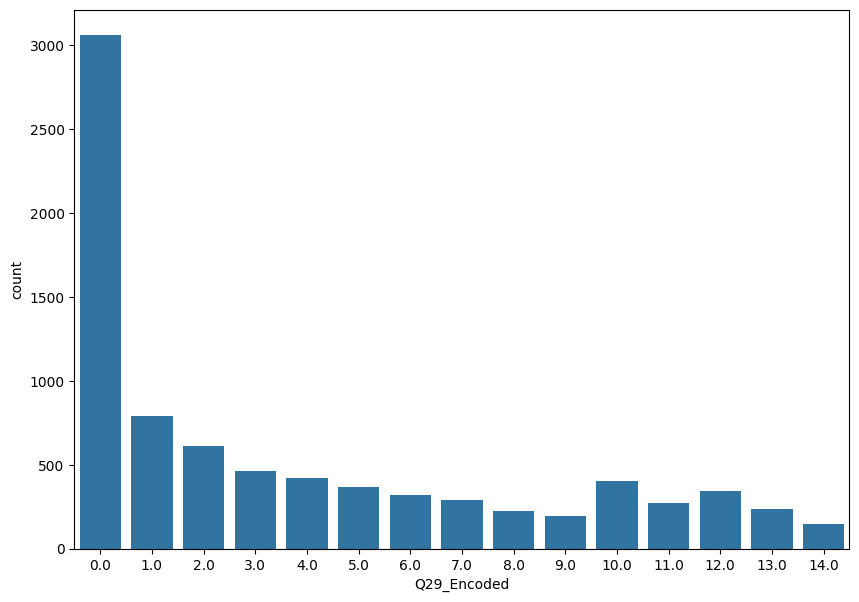

In [44]:
#%matplotlib inline

#plt.hist(df_encoded['Q29_Encoded'].sort_values(), bins=14, edgecolor='black')
#plt.title("Salary Histogram")
#plt.xlabel("Salary Bin")
#plt.ylabel("Number of Samples")
#plt.xticks(rotation=45, ha='right')
#plt.show()

plt.figure(figsize=(10,7))
sns.countplot(x='Q29_Encoded', data=df_encoded)

We can begin feature selection by using **chi-squared** scores of all the features. It assesses how dependent each feature is to the target data. This method is very robust for categorical data (which most of ours are) and can capture non-linear relationships effectively. However, it doesn't take into account the relationships between features.

In [45]:
#Create X (features) and y (target variables) dataframes for feature selection
X = df_encoded.drop(columns=['Q29_Encoded', 'Q29_buckets'],axis=1)
y = df_encoded['Q29_Encoded']

#Calculate chi squared scores of all features
chi_scores = chi2(X,y)
chi_scores

(array([1.49669016e+01, 2.70703066e+01, 1.57342290e+01, 1.57491420e+01,
        8.25941343e+01, 9.95229685e+00, 3.70017668e+01, 1.48950021e+02,
        3.19155302e+01, 4.35966972e+01, 7.03862752e+01, 1.60619933e+01,
        1.28421226e+02, 5.22109577e+01, 1.31366277e+01, 2.59818273e+01,
        4.43590603e+01, 7.28008953e+00, 7.20369804e+01, 4.23624472e+01,
        1.44103444e+02, 1.43824952e+02, 2.64912150e+01, 2.20304817e+01,
        1.35670431e+01, 8.07884505e+02, 8.07825144e+01, 3.10338874e+01,
        4.13731616e+01, 9.47807727e+01, 1.55340007e+02, 1.24802804e+02,
        2.34276291e+01, 1.71896427e+01, 3.74296188e+01, 2.00971423e+01,
        1.14813226e+01, 1.24133723e+02, 1.51248596e+02, 4.14184603e+01,
        1.18629080e+02, 2.63003872e+01, 2.25390959e+01, 6.19666097e+01,
        5.85870674e+01, 3.67076698e+01, 3.00177209e+01, 2.11295765e+01,
        3.67940678e+01, 1.57846132e+01, 6.13641278e+01, 1.60220455e+02,
        1.95543351e+01, 7.44327265e+01, 3.17456708e+01, 1.834456

After running the code a few times, we set the number of selected features to 100; this is a good compromise between having many features and the model taking too long to train. We can plot the most important features based on their chi scores (higher score means more important), and we'll only be working with the highest 100.

According to the plot below, the most important feature seems to be Q4, particularly whether the respondent is from the USA, followed by Q16 (how long they've used ML methods) and Q26 (amount of individuals responsible for data science workloads in their workplace).

<Axes: title={'center': 'Top 20 Highest Chi-squared Features'}, ylabel='Chi-squared'>

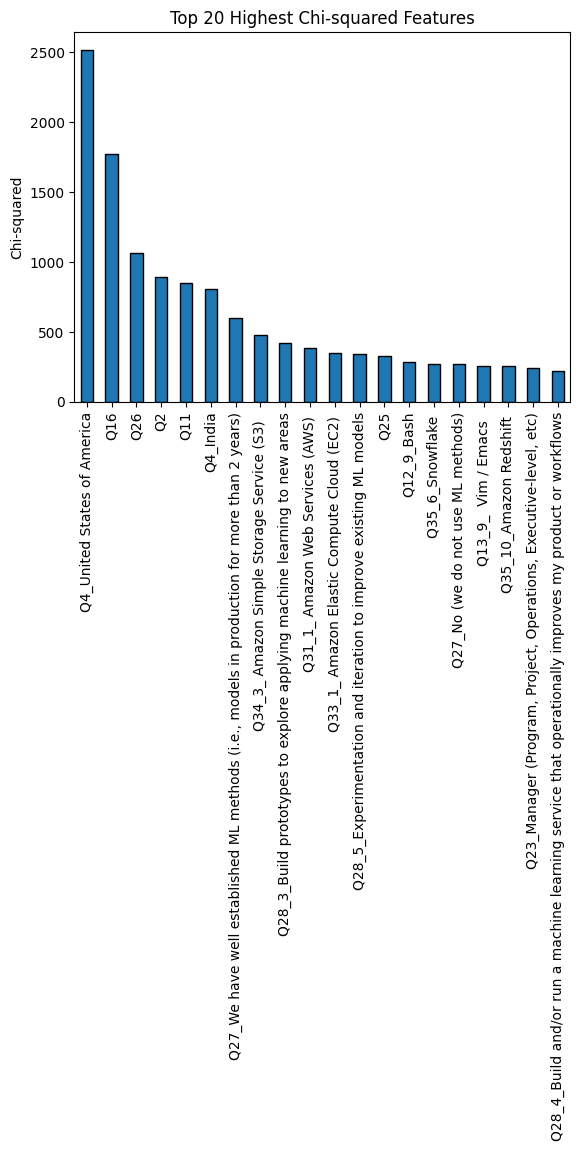

In [46]:
#Set number of features to be selected through chi squared
k = 100

#Plot chi squared of all encoded features, sorted from most important
chi_values = pd.Series(chi_scores[0], index=X.columns)
chi_values.sort_values(ascending=False, inplace=True)
plt.title("Top 20 Highest Chi-squared Features")
plt.ylabel("Chi-squared")
chi_values.head(20).plot.bar(edgecolor='black')

In [47]:
#Set features to be selected through K best
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]
selected_features #shows selected features in alphabetical order

Index(['Q3_Woman', 'Q4_Australia', 'Q4_Canada', 'Q4_France', 'Q4_Germany',
       'Q4_India', 'Q4_Indonesia', 'Q4_Israel', 'Q4_Italy', 'Q4_Japan',
       'Q4_Netherlands', 'Q4_Nigeria', 'Q4_Pakistan', 'Q4_Spain',
       'Q4_United Kingdom of Great Britain and Northern Ireland',
       'Q4_United States of America', 'Q6_1_Coursera', 'Q6_2_edX',
       'Q6_5_Fast.ai', 'Q6_6_Udacity',
       'Q6_9_Cloud-certification programs (direct from AWS, Azure, GCP, or similar)',
       'Q6_10_University Courses (resulting in a university degree)',
       'Q6_12_Other', 'Q7_1_University courses', 'Q8_Doctoral degree',
       'Q8_I prefer not to answer',
       'Q10_2_Yes, the research made use of machine learning as a tool (applied research)',
       'Q12_2_R', 'Q12_9_Bash', 'Q13_2_ RStudio ', 'Q13_9_  Vim / Emacs  ',
       'Q14_6_ Amazon Sagemaker Studio ',
       'Q14_12_ Databricks Collaborative Notebooks ',
       'Q15_3_ Plotly / Plotly Express ', 'Q15_5_ Shiny ', 'Q17_4_ PyTorch ',
       'Q1

We can now revise our dataframe to contain only the features we've selected through the method above and the target variables (along with their buckets for description). Plotting Q16 against the target value Q29 for instance (being the second highest rated feature), we can see increasing Q16 does in fact correlate well with increasing Q29. (The 2.69 in this case is the mean, which is what we used to fill in nulls).

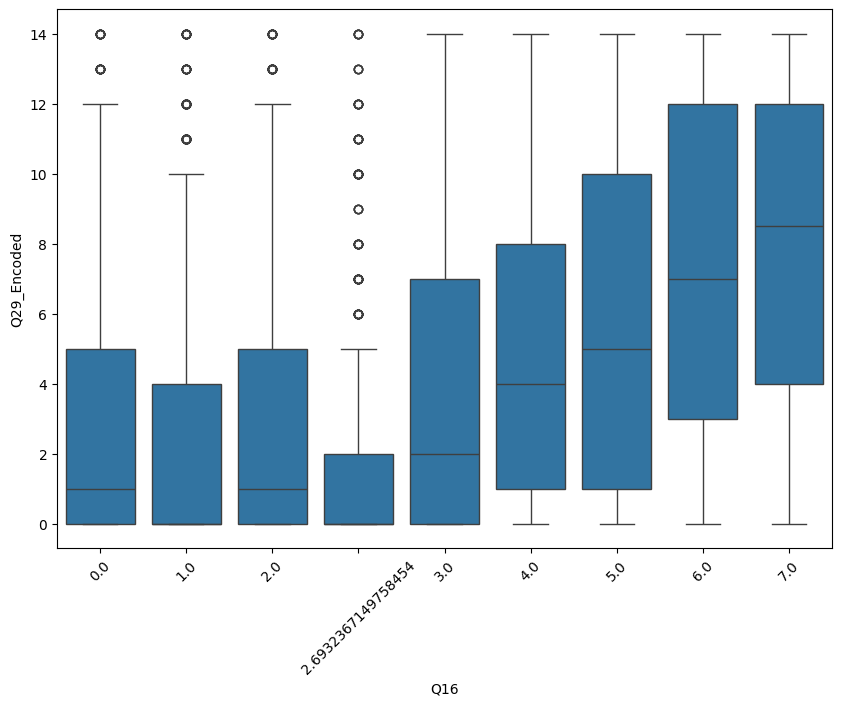

In [48]:
#Sort Q16 (example feature)
sorted_order = sorted(df_encoded['Q16'].unique())

#Plot Q16 against target variable (encoded Q29)
plt.figure(figsize=(10,7))
g = sns.boxplot(x='Q16', y='Q29_Encoded', data=df_encoded, order=sorted_order)
g.tick_params(axis='x', labelrotation=45)

In [49]:
#Filter encoded dataframe to only have selected features
df_selected = df_encoded[selected_features]
df_selected = pd.concat([df_encoded[selected_features],df_encoded[['Q29_Encoded','Q29_buckets']]], axis=1)
df_selected.head()

,Q3_Woman,Q4_Australia,Q4_Canada,Q4_France,Q4_Germany,Q4_India,Q4_Indonesia,Q4_Israel,Q4_Italy,Q4_Japan,...,"Q44_8_Blogs (Towards Data Science, Analytics Vidhya, etc)","Q44_9_Journal Publications (peer-reviewed journals, conference proceedings, etc)",Q2,Q11,Q16,Q25,Q26,Q30,Q29_Encoded,Q29_buckets
1,False,False,False,True,False,False,False,False,False,False,...,True,False,8.0,5.0,2.0,0,1,3.0,2.0,"20,000-29,999"
2,False,False,False,False,True,False,False,False,False,False,...,True,False,3.0,5.0,5.0,2,6,4.0,10.0,"100,000-124,999"
3,False,True,False,False,False,False,False,False,False,False,...,False,False,11.0,6.0,6.0,3,6,2.0,10.0,"100,000-124,999"
4,False,False,False,False,False,False,False,False,False,False,...,True,False,5.0,5.0,6.0,3,6,2.0,13.0,"200,000-299,999"
5,False,False,False,False,False,False,False,False,False,False,...,True,True,5.0,5.0,6.0,3,2,6.0,13.0,"200,000-299,999"


## 3. Model Implementation
First we create our X and y dataframes by seperating our features and our target data. Then we split them into 80% training set, 20% testing set.

After that, we can try out scikit's *LogisticRegression* function to create our ordinal logistic regression algorithm. One **hyperparameter** that we can tweak from here is **C**, which is the regularization parameter (L1 in most solvers of this function). We can create a for-loop to test out different values of C and how it'll affect the goodness of fit of the model compared to the training set (measured through R2).

In [50]:
#Create X and y dataframes for splitting and training
X = df_selected.drop(columns=['Q29_Encoded', 'Q29_buckets'],axis=1)
y = df_selected['Q29_Encoded']

#Split X and y with an 80:20 training-to-testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6508, 100)
X_test shape: (1628, 100)
y_train shape: (6508,)
y_test shape: (1628,)


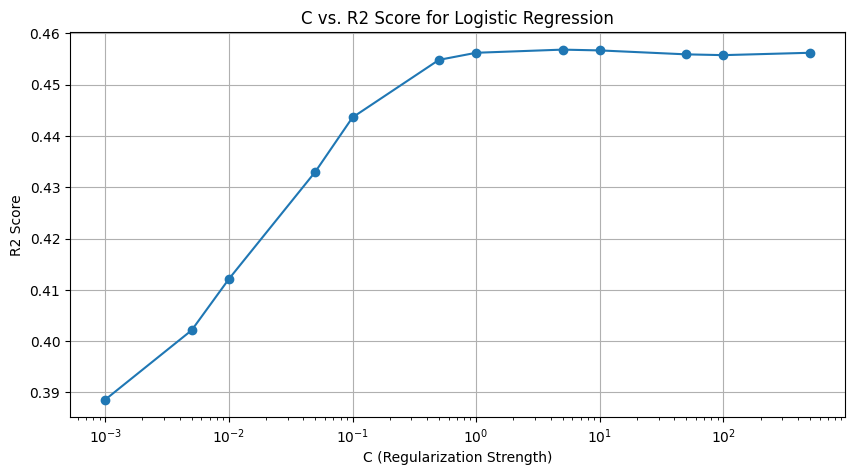

In [51]:
C = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500]
score = []

for C_val in C:
    model = LogisticRegression(C=C_val, solver='lbfgs',multi_class='multinomial',max_iter=10000)
    model.fit(X_train, y_train)
    score_val = model.score(X_train, y_train) #R2 score
    score.append(score_val)

plt.figure(figsize=(10, 5))
plt.semilogx(C, score, marker='o')
plt.title("C vs. R2 Score for Logistic Regression")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("R2 Score")
plt.grid(True)
plt.show()

The plot shows that higher C results in higher R2 up until a certain point then it levels out. We will be doing a more extensive hyperparameter tuning later, but this plot simply shows us that with higher C (introducing a little **bias**), **variance** is reduced much more, resulting in higher accuracy.

In [52]:
#Find out which C value corresponds to highest accuracy
Cmax = C[score.index(max(score))]
print('Highest R2: '+str(max(score))
     +'\nC value: '+str(Cmax))

Highest R2: 0.4568223724646589
C value: 5


Here, we try normalizing the feature dataset and re-fitting the model using the same hyperparameter to see how it affects the R2. We learn that the score changes very little (under 1%), and so **scaling is not that necessary in this case.** This is possibly because the value ranges of the features we're using are not significantly different (most are one-hot encoded, so their ranges are 0-1, while some ordinal features only go up to 6 or 7). This means even if unscaled, the features will not "outweigh" each other.

In [66]:
#Scale training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Repeat model fitting for scaled data
# model = LogisticRegression(C=Cmax,solver='lbfgs', multi_class='ovr',max_iter=10000)
model = LogisticRegression(C=Cmax,solver='lbfgs', multi_class='multinomial',max_iter=10000)
model.fit(X_train, y_train)
score = model.score(X_train, y_train)

score

0.45691656424962446

In [67]:
#Scale training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

#Initiate model (with mostly default hyperparameters)
# model = LogisticRegression(solver='lbfgs', multi_class='ovr')
model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

We can proceed with the **10-fold cross-validation** using *kfold*, and using **negative log-loss** as the performance metric. Using accuracy here might not be appropriate since we are working with an ordinal logistic regression model, and accuracy does not take into account the ordinal nature of the target variable (it treats all "misclassifications" the same, disregarding to what degree it is misclassified based on how far the target variable relatively is in the ordinal ranking).

We can then **plot the training scores and the cross-validation scores for different training examples** (sample sizes). We find that for higher training examples, the training score neg log-loss decreases, but the cross-validation score increases. This is another example of bias-variance tradeoff: Fitting the model *less* to training data actually makes it fit *more* to the cross-validation data.

In [55]:
#Perform 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_log_loss')

#Print cross-validation scores
print("Cross-Validation Scores:")
for fold, score in enumerate(scores, 1):
    print(f"Fold {fold}: {score:.4f}")

Cross-Validation Scores:
Fold 1: -1.9891
Fold 2: -1.9703
Fold 3: -1.8770
Fold 4: -1.9296
Fold 5: -2.0010
Fold 6: -1.8583
Fold 7: -1.9376
Fold 8: -1.9297
Fold 9: -1.9750
Fold 10: -1.9289


In [56]:
#Calculate average and variance of accuracies
mean_nll = np.mean(scores)
variance_nll = np.var(scores)

#Print average and variance
print("Average Neg. Log-Loss:", mean_nll)
print("Variance of Neg. Log-Loss:", variance_nll)

Average Neg. Log-Loss: -1.9396512342208432
Variance of Neg. Log-Loss: 0.0019249445270079144


In [72]:
#Define the function to plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='neg_log_loss'):
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="red")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="green")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt


InvalidParameterError: The 'scoring' parameter of learning_curve must be a str among {'precision_samples', 'recall', 'f1_samples', 'precision', 'explained_variance', 'recall_macro', 'jaccard_micro', 'v_measure_score', 'recall_weighted', 'neg_mean_squared_log_error', 'accuracy', 'matthews_corrcoef', 'jaccard_weighted', 'precision_weighted', 'neg_mean_absolute_percentage_error', 'f1_micro', 'roc_auc_ovr_weighted', 'adjusted_rand_score', 'precision_macro', 'neg_mean_squared_error', 'jaccard_macro', 'max_error', 'balanced_accuracy', 'f1_weighted', 'normalized_mutual_info_score', 'recall_micro', 'positive_likelihood_ratio', 'roc_auc_ovo', 'precision_micro', 'neg_brier_score', 'jaccard', 'mutual_info_score', 'neg_root_mean_squared_error', 'average_precision', 'neg_negative_likelihood_ratio', 'roc_auc_ovo_weighted', 'neg_mean_absolute_error', 'roc_auc_ovr', 'f1_macro', 'neg_mean_poisson_deviance', 'completeness_score', 'neg_mean_gamma_deviance', 'r2', 'fowlkes_mallows_score', 'top_k_accuracy', 'f1', 'recall_samples', 'jaccard_samples', 'adjusted_mutual_info_score', 'neg_log_loss', 'homogeneity_score', 'neg_median_absolute_error', 'roc_auc', 'rand_score'}, a callable or None. Got 'loss' instead.

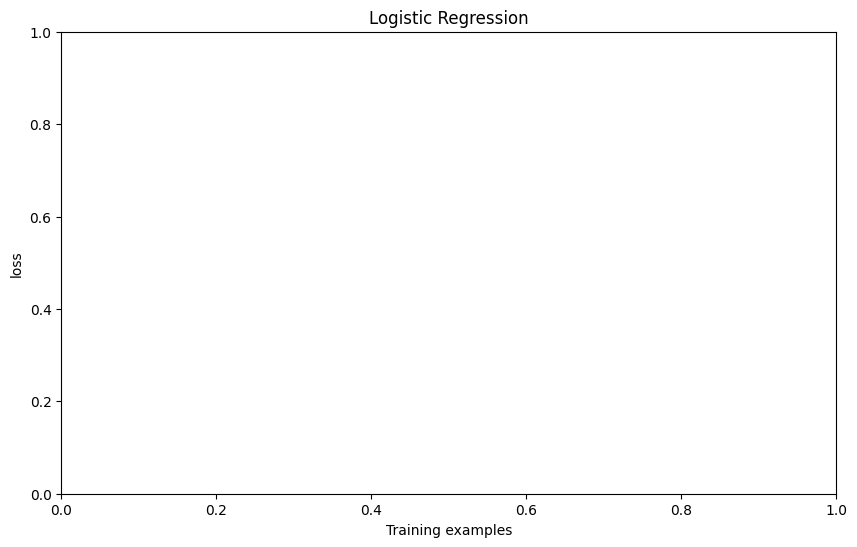

In [73]:
#Plot the training & cross validation scores for different sample sizes (10-fold CV)
plot_learning_curve(model,'Logistic Regression', X, y, cv=10)

## 4. Model Tuning

Now we can begin **hyperparameter tuning** (for C) in our logistic regression model using **grid search** and 10-fold cross validation. The code below loops through different C values (and tries different solvers) and evaluates the model's accuracies. The C with the highest accuracy results in the most optimized model. We then use this C for our model and fit it with the training dataset, then use it to predict the test dataset.

In [59]:
#Tune hyperparameter C using grid search
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 10000, 100000]:
    for solver in ['newton-cg','lbfgs','sag']:
        
        model = LogisticRegression(C=C, solver=solver, multi_class='multinomial')
        accuracy = np.zeros(10)
        log_loss_values = []
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            TN = confusion_matrix(y_test, predictions)[0][0]
            FP = confusion_matrix(y_test, predictions)[0][1]
            FN = confusion_matrix(y_test, predictions)[1][0]
            TP = confusion_matrix(y_test, predictions)[1][1]
            total = TN + FP + FN + TP
            ACC = (TP + TN) / float(total)

            accuracy[np_idx] = ACC*100
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 100, 'solver': 'lbfgs'}
Best Score: 79.816%(1.852%)

The optimal log model uses C=100, and a lbfgs solver, and has a cross validation score of 79.816% with a standard deviation of 1.852%


In [60]:
#Apply the optimal hyperparameter C into model and re-fit training data
model = LogisticRegression(C=best_params['C'],solver=best_params['solver'],multi_class='multinomial')
model.fit(X_train, y_train)

#Predict target variables using "optimal" model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [61]:
#Checking probabilities for each y-value
y_test_prob = model.predict_proba(X_test)
for i, probs in enumerate(y_test_prob):
    class_label = model.classes_
    print(f"Probabilities for data point {i}:")
    for label, prob in zip(class_label, probs):
        print(f"Class {label}: {prob:.3f}")

Probabilities for data point 0:
Class 0.0: 0.093
Class 1.0: 0.177
Class 2.0: 0.276
Class 3.0: 0.126
Class 4.0: 0.052
Class 5.0: 0.051
Class 6.0: 0.090
Class 7.0: 0.054
Class 8.0: 0.026
Class 9.0: 0.031
Class 10.0: 0.013
Class 11.0: 0.006
Class 12.0: 0.003
Class 13.0: 0.002
Class 14.0: 0.001
Probabilities for data point 1:
Class 0.0: 0.172
Class 1.0: 0.040
Class 2.0: 0.044
Class 3.0: 0.149
Class 4.0: 0.076
Class 5.0: 0.122
Class 6.0: 0.081
Class 7.0: 0.065
Class 8.0: 0.186
Class 9.0: 0.008
Class 10.0: 0.034
Class 11.0: 0.016
Class 12.0: 0.000
Class 13.0: 0.007
Class 14.0: 0.000
Probabilities for data point 2:
Class 0.0: 0.666
Class 1.0: 0.180
Class 2.0: 0.072
Class 3.0: 0.036
Class 4.0: 0.024
Class 5.0: 0.004
Class 6.0: 0.008
Class 7.0: 0.003
Class 8.0: 0.001
Class 9.0: 0.001
Class 10.0: 0.002
Class 11.0: 0.001
Class 12.0: 0.000
Class 13.0: 0.000
Class 14.0: 0.001
Probabilities for data point 3:
Class 0.0: 0.274
Class 1.0: 0.127
Class 2.0: 0.054
Class 3.0: 0.106
Class 4.0: 0.060
Class 5

## 5. Testing & Discussion

Since we've predicted the y values (target variables), we can compare them with the actual values in a dataframe. To quantify the performance of our model with the optimized hyperparameter, we simply compute the MAE, MSE, and accuracy of our predictions versus the actual values.

In [62]:
#Display actual target variable vs predicted target variable for testing set
resultsDF = pd.DataFrame(y_test)
resultsDF.columns = ['Actual']
resultsDF['Predictions'] = pd.Series(y_test_pred)
resultsDF

,Actual,Predictions
0,2.0,2.0
1,0.0,8.0
2,0.0,0.0
3,9.0,0.0
4,0.0,0.0
...,...,...
808,10.0,11.0
809,0.0,0.0
810,0.0,0.0
811,2.0,0.0


In [63]:
#Evaluate the errors and accuracy of the dataset
MAE = mean_absolute_error(resultsDF['Actual'],resultsDF['Predictions'])
MSE = mean_squared_error(resultsDF['Actual'],resultsDF['Predictions'])
accuracy = accuracy_score(resultsDF['Actual'],resultsDF['Predictions'])

print("Mean absolute error: "+str(MAE)
     +"\nMean squared error: "+str(MSE)
     +"\nAccuracy: "+str(accuracy * 100))

Mean absolute error: 2.063960639606396
Mean squared error: 11.690036900369003
Accuracy: 40.09840098400984


We can also show which features actually ended up being the most important based on their coefficients from the model. The most important is Q4 (whether they're from the USA), followed by Q2 (their age), then Q4 again (whether they're from Pakistan or India).

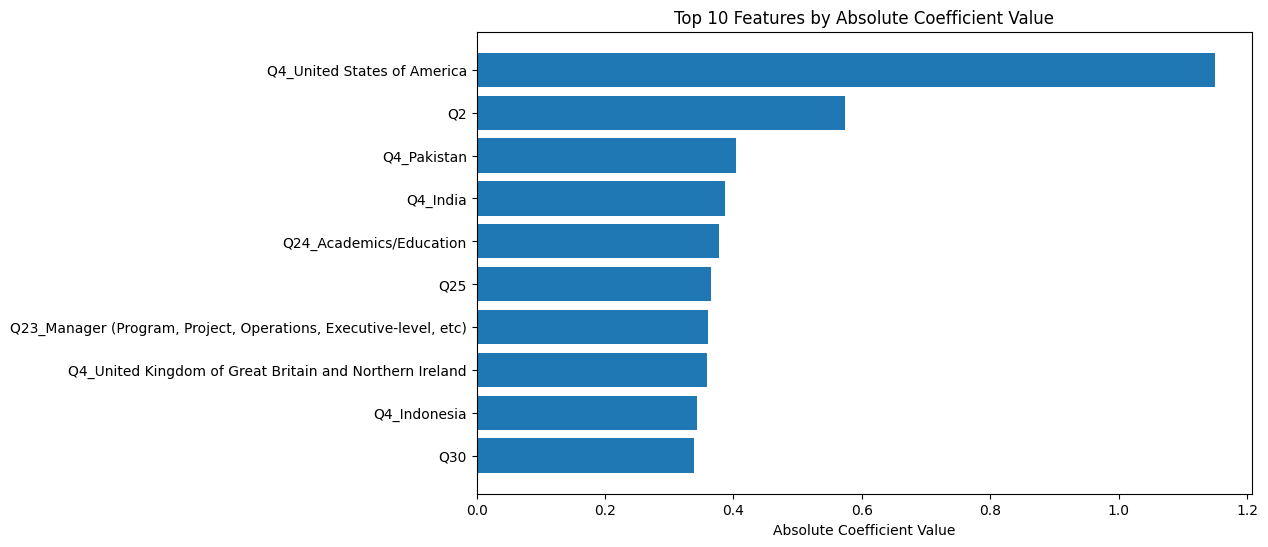

In [64]:
#Calculate the absolute values of coefficients
abs_coefficients = np.abs(model.coef_)

#Get the indices that sort the coefficients in descending order
indices = np.argsort(abs_coefficients)[0][::-1]

#List of feature names in the same order as they appear in X
feature_names = X.columns

#List the most important features
n_top_features = 10  # Change this number to the desired number of top features
top_features = [feature_names[i] for i in indices[:n_top_features]]

#Plot coefficient values for (actual) most important features
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), abs_coefficients[0, indices[:n_top_features]], align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Absolute Coefficient Value')
plt.title('Top {} Features by Absolute Coefficient Value'.format(n_top_features))
plt.gca().invert_yaxis()  #Invert the y-axis to display the most important feature at the top
plt.show()

Finally, we can **plot** our **distribution of target values** for both the training set and the test set. We can see on the graph that the distribution function of our model and the actual target data are close, but not quite the same.

The accuracy in the testing set is actually worse at around 40%, whereas it was almost 80% during hyperparameter tuning using the training set. This might imply that the model is still **overfit** to the training set, possibly because we didn't loop through high enough values of hyperparameter C, or because we used accuracy as a performance metric during the grid search (instead of log-loss).

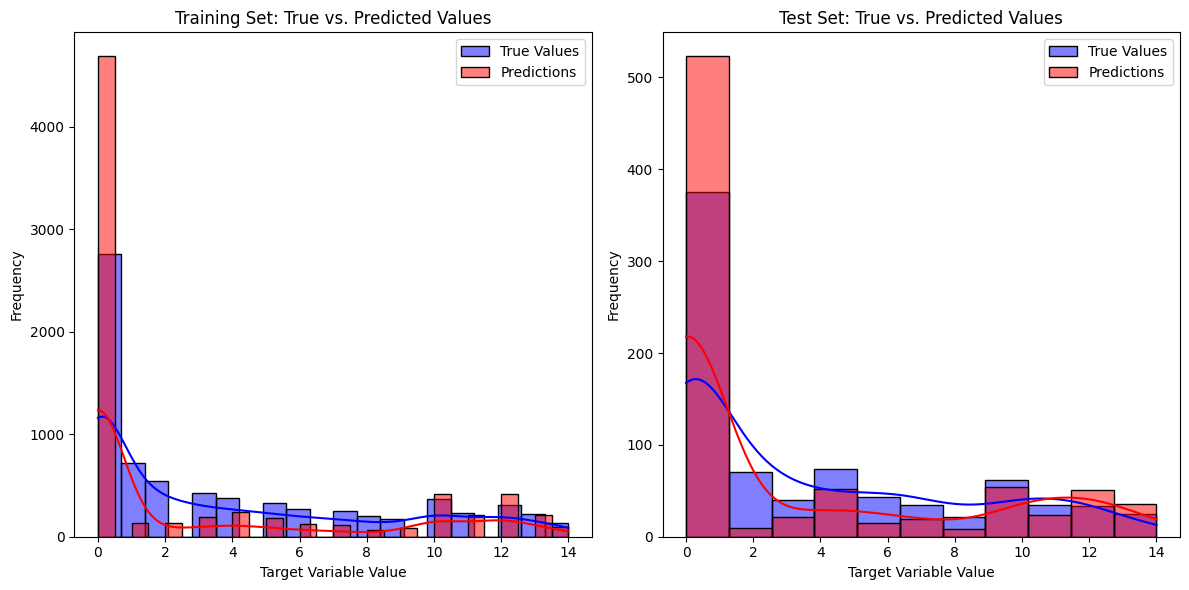

In [65]:
#Create a new figure
plt.figure(figsize=(12, 6))

#Plot the distribution of true target values on the training set
plt.subplot(1, 2, 1)  # Create a subplot for the training set
sns.histplot(y_train, kde=True, color='blue', label='True Values')
sns.histplot(y_train_pred, kde=True, color='red', label='Predictions')
plt.title('Training Set: True vs. Predicted Values')
plt.xlabel('Target Variable Value')
plt.ylabel('Frequency')
plt.legend()

#Plot the distribution of true target values on the test set
plt.subplot(1, 2, 2)  #Create subplot for the test set
sns.histplot(y_test, kde=True, color='blue', label='True Values')
sns.histplot(y_test_pred, kde=True, color='red', label='Predictions')
plt.title('Test Set: True vs. Predicted Values')
plt.xlabel('Target Variable Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()  #Ensure subplots do not overlap
plt.show()